In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import os, sys, pathlib, random, time, pickle, copy, json
from tqdm import tqdm

In [2]:
device = torch.device("cuda:0")

In [3]:
import torch.optim as optim
from torch.utils import data

## Connected Metric

In [4]:
class ConnectedClassifier_SoftKMeans(nn.Module):
    
    def __init__(self,input_dim, num_sets, output_dim, inv_temp=0):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_sets = num_sets
        self.inv_temp = nn.Parameter(torch.ones(1)*inv_temp)
        
        self.centers = nn.Parameter(torch.rand(num_sets, input_dim)*2-1)
        
        init_val = torch.randn(num_sets, output_dim)*0.1
        for ns in range(num_sets):
            init_val[ns, ns%output_dim] = 0.43
        self.cls_weight = nn.Parameter(init_val)

        self.cls_confidence = None
        
        
    def forward(self, x, hard=False):
        
        dists = torch.cdist(x, self.centers)
        dists = dists/np.sqrt(self.input_dim) ### correction to make diagonal of unit square 1 in nD space
        dists = dists*torch.exp(self.inv_temp)

        if hard:
            x = torch.softmax(-dists*1e9, dim=1)
        else:
            x = torch.softmax(-dists, dim=1)
        self.cls_confidence = x.data.cpu()
        c = self.cls_weight
        return x@c ## since both are normalized, it is also normalized

    def set_centroid_to_data_randomly(self, xx_, yy_, model):
        num_centers = self.centers.shape[0]
        yout = model(xx_.to(device)).data.cpu()
        
        yout = yout[:num_centers].to(self.centers.device)
        yy = yy_[:num_centers].to(self.centers.device)
        
        self.centers.data = yout
        
        init_val = torch.randn(self.num_sets, self.output_dim)
        for ns in range(num_centers):
            init_val[ns, yy[ns]] = 5
        self.cls_weight.data = init_val.to(self.cls_weight.device)
        pass

## Test on toy classification

In [5]:
from sklearn import datasets

In [6]:
np.random.seed(258) ## 249, 258

xxc, yc = datasets.make_circles(n_samples=265, factor=.5,
                                      noise=.07)
idx = yc==0
xxc = xxc[idx]
yc = yc[idx]

idx = (xxc[:,0]+xxc[:,1]<1)
xxc = xxc[idx]
yc = yc[idx]


xxm, ym = datasets.make_moons(n_samples=200, noise=.15)
xxm = xxm/2 - 0.2

xx = np.concatenate((xxm, xxc), axis=0)
y = np.concatenate((ym, yc+2), axis=0)

In [7]:
xx_, y_ = datasets.make_blobs(n_samples=100, 
                              n_features=2, 
                              centers=np.array([[-1,-1], [-1, 1]]), 
                              cluster_std=0.1)

In [8]:
xx_.shape, y_.shape

((100, 2), (100,))

In [9]:
xx = np.concatenate((xx, xx_), axis=0)
y = np.concatenate((y, y_), axis=0)

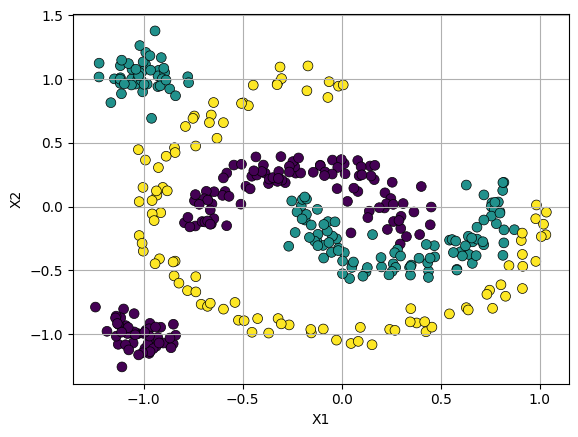

In [10]:
## MinMax Normalization
x1 = xx[:,0]
x2 = xx[:,1]
# x1 = (x1-x1.min())/(x1.max()-x1.min())
# x2 = (x2-x2.min())/(x2.max()-x2.min())
xx = np.column_stack((x1,x2))

xx = torch.Tensor(xx)
yy = torch.Tensor(y.reshape(-1, 1))

%matplotlib inline
plt.scatter(x1, x2, c=y, s=50, edgecolors='k', lw=0.5)

# (x1min, x1max) = -0.1, 1.1
# plt.xlim((x1min, x1max))
# plt.ylim((x1min, x1max))
plt.xlabel("X1")
plt.ylabel('X2')
plt.grid()

In [11]:
ycls = yy.reshape(-1).type(torch.long)

## Test using multi-invex classifier

In [12]:
import nflib
from nflib.flows import SequentialFlow, NormalizingFlow, ActNorm, AffineConstantFlow
import nflib.coupling_flows as icf
import nflib.res_flow as irf

number of params:  0
Training FOR: ./invex_out/connected_convex/expv0_convex_N3


  4%|█▊                                             | 378/10000 [00:00<00:09, 1018.46it/s]

Epoch: 499 Loss: 1.045152187347412 Accuracy: 0.4812967777252197
		 Hard Accuracy: 0.471321702003479


  5%|██▍                                             | 499/10000 [00:00<00:15, 596.06it/s]

KeyboardInterrupt



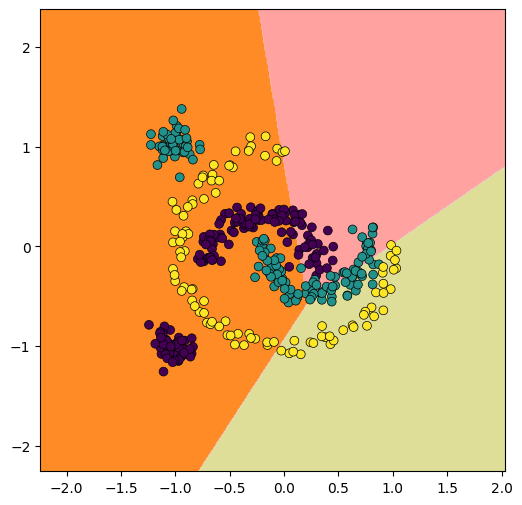

In [13]:
### experiment hyperparameters

# inv = False ## [False, True]
# nodes = 17  ## [3, 5, 8, 12, 17]

seed = 258
output_dict = {}

xx = xx.to(device)
ycls = ycls.to(device)

for nodes in [3, 5, 7, 9, 11, 13, 15, 17]:
# for nodes in [17]:
    for inv in [False, True]:
        
        torch.manual_seed(seed)
        np.random.seed(seed)
        classifier = ConnectedClassifier_SoftKMeans(2, nodes, 3).to(device)

        model_name = f'expv0'

        if inv:
            model_name += '_invex'
            actf = irf.LeakyReLU
            flows = [
                ActNorm(2),
                irf.ResidualFlow(2, [20, 20], activation=actf),
                ActNorm(2),
                irf.ResidualFlow(2, [20, 20], activation=actf),
                ActNorm(2),
                irf.ResidualFlow(2, [20, 20], activation=actf),
                ActNorm(2),
                    ]

            model = nn.Sequential(*flows).to(device)
        else:
            model_name += '_convex'
            model = nn.Identity().to(device)

        ## add number of nodes
        model_name += f'_N{nodes}'


        criterion = nn.CrossEntropyLoss()

        optimizer = optim.Adam(list(model.parameters())+list(classifier.parameters()), lr=0.001)
        print("number of params: ", sum(p.numel() for p in model.parameters()))

        losses = []
        NUM = 512
        ### for plotting in 2d grid
        ng = 400
        # _a,_b,_c,_d = x1.min()-0.1, x1.max()+0.1, x2.min()-0.1, x2.max()+0.1
        s = 1.0
        _a,_b,_c,_d = x1.min()-s, x1.max()+s, x2.min()-s, x2.max()+s
        xg, yg = np.linspace(_a, _b, ng), np.linspace(_c, _d, ng)
        xg, yg = np.meshgrid(xg, yg)
        xyg = np.stack([xg.reshape(-1), yg.reshape(-1)], axis=-1)
        xyg = torch.Tensor(xyg).to(device)


        best_acc = -1
        hard_acc = -1

        model_name = f'./invex_out/connected_convex/'+model_name
        print(f"Training FOR: {model_name}")
        for epoch in tqdm(range(1000*10)):
            optimizer.zero_grad()

            if epoch < 1000:
                with torch.no_grad():
                    tmp_ = model(xx)
            else:
                tmp_ = model(xx)
            yout = classifier(tmp_)

            loss = criterion(yout, ycls)
            loss.backward()
            optimizer.step()

            if (epoch+1)%500 == 0:

                with torch.no_grad():
                    yout = classifier(model(xx))
                    yout_img = classifier(model(xyg))
                    out = yout_img.data.argmax(dim=1).cpu().numpy()

                acc = (yout.data.argmax(dim=1) == ycls)
                acc = float(acc.type(torch.float32).mean())
                losses.append(float(loss))
                print(f"Epoch: {epoch} Loss: {losses[-1]} Accuracy: {acc}")
                if acc > best_acc: best_acc = acc

                fig = plt.figure(figsize=(6, 6))
                cf = plt.contourf(xg, yg, out.reshape(xg.shape),# v,
                                 alpha=0.5, antialiased=True)
                plt.scatter(x1, x2, c=ycls.cpu().numpy().reshape(-1), s=40, edgecolors='k', lw=0.5)
#                 plt.scatter(x1, x2, c=ycls.cpu().numpy().reshape(-1), s=40)
                plt.savefig(f"{model_name}_clf.pdf", bbox_inches='tight')
                plt.close()


                with torch.no_grad():
                    yout = classifier(model(xx), hard=True)
                    yout_img = classifier(model(xyg), hard=True)
                    out = yout_img.data.argmax(dim=1).cpu().numpy()

                acc = (yout.data.argmax(dim=1) == ycls)
                acc = float(acc.type(torch.float32).mean())
                losses.append(float(loss))
                print(f"\t\t Hard Accuracy: {acc}")
                if acc > hard_acc: hard_acc = acc


                fig = plt.figure(figsize=(6, 6))
                cf = plt.contourf(xg, yg, out.reshape(xg.shape),# v,
                                 alpha=0.5, antialiased=True)
                plt.scatter(x1, x2, c=ycls.cpu().numpy().reshape(-1), s=40, edgecolors='k', lw=0.5)
#                 plt.scatter(x1, x2, c=ycls.cpu().numpy().reshape(-1), s=40)
                plt.savefig(f"{model_name}_hard_clf.pdf", bbox_inches='tight')
                plt.close()


                fig = plt.figure(figsize=(6, 6))
                cf = plt.contourf(xg, yg, classifier.cls_confidence.data.argmax(dim=1).cpu().numpy().reshape(xg.shape),
                                 alpha=0.9, antialiased=True, levels=classifier.num_sets, cmap='tab20')
                plt.scatter(x1, x2, c=ycls.cpu().numpy().reshape(-1), s=40, edgecolors='k', lw=0.5)
#                 plt.scatter(x1, x2, c=ycls.cpu().numpy().reshape(-1), s=40)
                plt.savefig(f"{model_name}_clf_db.pdf", bbox_inches='tight')
                plt.close()

        ## when the training is finished
        output_dict[model_name] = {'acc':best_acc, 'hard_acc':hard_acc}
        ## save the dict to json
        with open(f"./invex_out/connected_convex/benchmark_v0_data.json", 'w') as f:
            json.dump(output_dict, f, indent=0)

In [ ]:
# !mkdir ./invex_out/connected_convex